# Notebook to evaluate the model
Contains code to evaluate the model and generate the confusion matrix.
Also contains code to visualize the confusion matrix with images.
Has export code to save the misclassified images with their true and predicted labels.

In [2]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, transforms
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix as cmatrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

In [3]:
os.chdir('/home/jupyter')

In [87]:
plt.rcParams['font.size'] = 14  # Set the base font size
plt.rcParams['axes.labelsize'] = 16  # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 14

In [ ]:
template_base_dir = 'train_sub/train_data'
TEST_ROOT ='data/test_data'
mean=[0.5166, 0.4564, 0.4966]
std=[0.2095, 0.2283, 0.2123]

## Load the model

In [4]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=3, padding=1, bias=False)  # Output size: 96 x 96 x 100
        self.norm1 = nn.BatchNorm2d(num_features=100)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 48 x 48 x 100
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=3, padding=1, bias=False)  # Output size: 48 x 48 x 150
        self.norm2 = nn.BatchNorm2d(num_features=150)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 24 x 24 x 150
        self.conv3 = nn.Conv2d(in_channels=150, out_channels=250, kernel_size=3, padding=1, bias=False)  # Output size: 24 x 24 x 250
        self.norm3 = nn.BatchNorm2d(num_features=250)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 12 x 12 x 250
        # Calculate the total number of features in the flattened feature map
        flat_features = 12 * 12 * 250
        self.fc1 = nn.Linear(in_features=flat_features, out_features=4000)  # Output: 4000 units
        self.fc2 = nn.Linear(in_features=4000, out_features=200)  # Output: 200 units
        self.fc3 = nn.Linear(in_features=200, out_features=38)  # Output: 46 units

    def forward(self, x):
        x = self.pool1(self.norm1(F.relu(self.conv1(x))))
        x = self.pool2(self.norm2(F.relu(self.conv2(x))))
        x = self.pool3(self.norm3(F.relu(self.conv3(x))))
        x = torch.flatten(x, start_dim=1)  # Flatten starting from dimension 1
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# Create model instance
model = CNN1()

# Load the model weights
MODDEL_PATH = ''
state_dict = torch.load(MODDEL_PATH, map_location='cpu')
    
model.load_state_dict(new_state_dict)

## Load the test dataset

In [94]:
# Load the validation dataset
transform = transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std) # means and std calculated from the training data
        ])
test_dataset = datasets.ImageFolder(root=TEST_ROOT, transform=transform)
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}  # Invert the dictionary

In [95]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8)

In [11]:
model.eval()

CNN1(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(150, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36000, out_features=4000, bias=True)
  (fc2): Linear(in_features=4000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=38, bias=True)


In [20]:
predictions = np.load("8/confusion_matrix_8.npy")

In [12]:
device = 'cpu'

# Make confusion matrix

In [23]:
num_classes = 38 

# Initialize lists to store predictions and labels
all_pred_probs = []
all_true_labels = []

# Iterate over the test dataset
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): 
        output = model(data)
    
    # Convert output probabilities using softmax (if your model doesn't include a final softmax layer)
    pred_probs = torch.softmax(output, dim=1).cpu().numpy()
    
    # Convert true labels to binary format
    true_labels = torch.nn.functional.one_hot(target, num_classes=num_classes).cpu().numpy()
    
    # Append the results to the list
    all_pred_probs.append(pred_probs)
    all_true_labels.append(true_labels)

# Concatenate all batches to get the full arrays
all_pred_probs = np.concatenate(all_pred_probs, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

In [81]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = cmatrix(all_labels, all_preds, labels=np.arange(len(idx_to_class)))

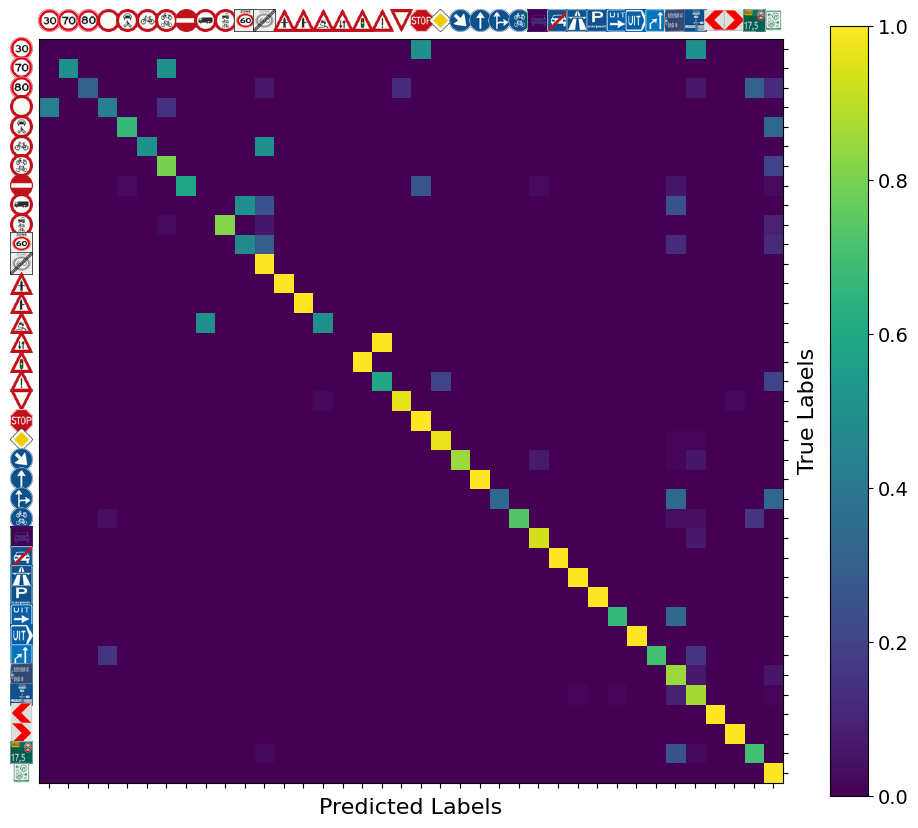

In [88]:
order = ['A1-30', 'A1-70', 'A1-80', 'C1', 'C12', 'C14', 'C15', 'C2', 'C7', 'C9', 'A01-60-ZB', 'A02-60-ZE','B3', 'B5', 'J20', 'J29', 'J32', 'J37', 'B6', 'B7', 'B1', 'D2', 'D4', 'D6', 'G12-A', 'G3', 'G4', 'G1', 'E13', 'BB_G', 'BB_K', 'L', 'K_K', 'K', 'BB12l', 'BB12r', 'BB10', 'BW410']


confusion_matrix = cm
# Normalize the confusion matrix
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Base directory where the template images are stored
template_base_dir = 'data/train_templates'

# Provide your custom order of class names
custom_order = order

# Create a mapping of class names back to indices
class_to_idx = {v: k for k, v in idx_to_class.items()}

# Find indices that correspond to your custom order
sorted_indices = [class_to_idx[name] for name in custom_order]

# Reorder the confusion matrix and load images in the sorted order
sorted_confusion_matrix = confusion_matrix[np.ix_(sorted_indices, sorted_indices)]
sorted_images = []
for idx in sorted_indices:
    folder_path = os.path.join(template_base_dir, idx_to_class[idx])
    template_image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    image = Image.open(template_image_path).resize((32, 32))  # Resize for better handling in plot
    sorted_images.append(image)

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(sorted_confusion_matrix, cmap='viridis')

# Adding images as tick labels
for i, img in enumerate(sorted_images):
    imagebox = OffsetImage(img, zoom=0.5)  # Adjust zoom level if needed
    xy = (i, 0)  # Position for x-axis images
    ab = AnnotationBbox(imagebox, xy, xybox=(0, 20), xycoords='data', boxcoords="offset points", pad=0, frameon=False)
    ax.add_artist(ab)
    xy = (0, i)  # Position for y-axis images
    ab = AnnotationBbox(imagebox, xy, xybox=(-20, 0), xycoords='data', boxcoords="offset points", pad=0, frameon=False)
    ax.add_artist(ab)

ax.set_xticks(np.arange(len(idx_to_class)))
ax.set_yticks(np.arange(len(idx_to_class)))
ax.set_xticklabels([''] * len(idx_to_class))  
ax.set_yticklabels([''] * len(idx_to_class))

ax.yaxis.set_label_position("right")  
ax.yaxis.tick_right() 
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
#ax.set_title('Confusion Matrix with Image Labels')
plt.colorbar(im, ax=ax)
plt.savefig('plots/confused.png')
plt.show()



# Plot random misclassified images

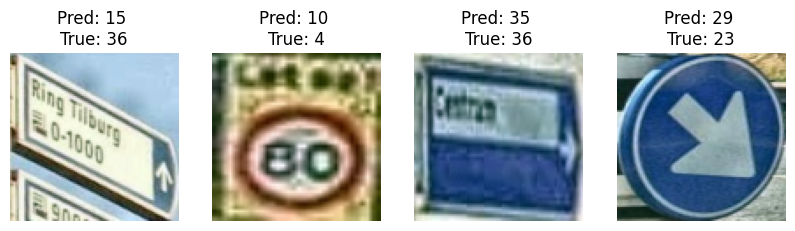

In [83]:
model.eval()
misclassified_images = []
misclassified_labels = []
correct_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Collect misclassified images and their labels
        misindexes = preds != labels
        if any(misindexes):
            misclassified_images.extend(images[misindexes].cpu())
            misclassified_labels.extend(preds[misindexes].cpu())
            correct_labels.extend(labels[misindexes].cpu())

# Convert lists to proper torch tensors for easy handling
misclassified_images = torch.stack(misclassified_images)
misclassified_labels = torch.tensor(misclassified_labels)
correct_labels = torch.tensor(correct_labels)

# Randomly select 4 misclassified images
indices = np.random.choice(range(len(misclassified_images)), 4, replace=False)
selected_images = misclassified_images[indices]
selected_preds = misclassified_labels[indices]
selected_true = correct_labels[indices]

# Plotting the selected misclassified images
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2.5))
for idx, ax in enumerate(axes):
    img = selected_images[idx].numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
    ax.imshow(img)
    ax.set_title(f'Pred: {selected_preds[idx]} \nTrue: {selected_true[idx]}')
    ax.axis('off')
plt.show()

# Save correctly classified images as PDF

In [ ]:
# Store correctly images, predictions, and true labels
misclassified = []

# Iterate over the test dataset
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

    # Check for misclassifications
    mis_idxs = (pred.squeeze() == target).nonzero(as_tuple=False)
    for idx in mis_idxs:
        img_path = os.path.join(template_base_dir, idx_to_class[pred[idx].item()])

        # Ensure directory exists and has files
        if os.path.isdir(img_path) and os.listdir(img_path):
            template_image = next(os.walk(img_path))[2][0]  # Take the first file in the directory
            template_image_path = os.path.join(img_path, template_image)
            misclassified.append((data[idx].cpu(), target[idx].item(), pred[idx].item(), template_image_path))
        else:
            print(f"No files in directory: {img_path}")

In [ ]:
def denormalize(image, means, stds):
    """
    De-normalizes a tensor image with mean and std.
    """
    means = torch.tensor(means).view(3, 1, 1)
    stds = torch.tensor(stds).view(3, 1, 1)
    return image * stds + means

means = mean  # adjust these values to your specific normalization
stds = std

with PdfPages('correct_classified_images.pdf') as pdf:
    for img, true, pred, template_path in misclassified:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

        # De-normalize and display misclassified image
        img = denormalize(img, means, stds)
        img = img.squeeze().permute(1, 2, 0)
        img = np.clip(img.numpy(), 0, 1)
        axes[0].imshow(img)
        axes[0].set_title(f'Classified as {idx_to_class[pred]}')
        axes[0].axis('off')

        # Display template image
        template_img = Image.open(template_path)
        axes[1].imshow(template_img)
        axes[1].set_title(f'Template of {idx_to_class[pred]}')
        axes[1].axis('off')

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure into pdf
        plt.close(fig)

print("PDF created with all correctly images.")

# Save misclassified images as PDF

In [ ]:
# Store misclassified images, predictions, and true labels
misclassified = []

# Iterate over the test dataset
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

    # Check for misclassifications
    mis_idxs = (pred.squeeze() != target).nonzero(as_tuple=False)
    for idx in mis_idxs:
        img_path = os.path.join(template_base_dir, idx_to_class[target[idx].item()])
        pred_path = os.path.join(template_base_dir, idx_to_class[pred[idx].item()])

        # Check for the presence of template images for both true and predicted classes
        if os.path.isdir(img_path) and os.listdir(img_path) and os.path.isdir(pred_path) and os.listdir(pred_path):
            true_template_image = next(os.walk(img_path))[2][0]  # First file in the directory
            true_template_image_path = os.path.join(img_path, true_template_image)
            pred_template_image = next(os.walk(pred_path))[2][0]  # First file in the directory
            pred_template_image_path = os.path.join(pred_path, pred_template_image)
            misclassified.append((data[idx].cpu(), target[idx].item(), pred[idx].item(), true_template_image_path, pred_template_image_path))
        else:
            print(f"Missing files in directory for class {idx_to_class[target[idx].item()]} or {idx_to_class[pred[idx].item()]}")

# Function to de-normalize images
def denormalize(image, means, stds):
    means = torch.tensor(means).view(3, 1, 1)
    stds = torch.tensor(stds).view(3, 1, 1)
    return image * stds + means

# PDF creation with detailed pages for each misclassification
means = [0.485, 0.456, 0.406]  # Example normalization means
stds = [0.229, 0.224, 0.225]  # Example normalization stds

with PdfPages('misclassified_images.pdf') as pdf:
    for img, true, pred, true_template_path, pred_template_path in misclassified:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

        # De-normalize and display misclassified image
        img = denormalize(img, means, stds)
        img = img.squeeze().permute(1, 2, 0)
        img = np.clip(img.numpy(), 0, 1)
        axes[0].imshow(img)
        axes[0].set_title(f'Misclassified as {idx_to_class[pred]}')
        axes[0].axis('off')

        # Display true class template image
        true_template_img = Image.open(true_template_path)
        axes[1].imshow(true_template_img)
        axes[1].set_title(f'True class: {idx_to_class[true]}')
        axes[1].axis('off')

        # Display predicted class template image
        pred_template_img = Image.open(pred_template_path)
        axes[2].imshow(pred_template_img)
        axes[2].set_title(f'Predicted class: {idx_to_class[pred]}')
        axes[2].axis('off')

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure into pdf
        plt.close(fig)

print("PDF created with all misclassified images and templates.")